### Start

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!rm -rf /content/train/
!rm -rf /content/test/


In [6]:
!unzip -q "/content/drive/MyDrive/train.zip" -d /content/train
!unzip -q "/content/drive/MyDrive/test.zip" -d /content/test

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import os

### Run a basic ResNet50 model with transfer learning, first locking theta1 parameters and training for 5 epochs and then releasing the lock on theta1 and training for 5 epochs

In [4]:
import os
import shutil

# ✅ Create proper structure
os.makedirs("/content/train/cats", exist_ok=True)
os.makedirs("/content/train/dogs", exist_ok=True)

# ✅ Move images from /content/train/train/* → /content/train/cats|dogs/
for filename in os.listdir("/content/train/train"):
    src_path = os.path.join("/content/train/train", filename)
    if os.path.isfile(src_path):
        if filename.startswith("cat"):
            shutil.move(src_path, f"/content/train/cats/{filename}")
        elif filename.startswith("dog"):
            shutil.move(src_path, f"/content/train/dogs/{filename}")

# ✅ (Optional) Delete the now-empty /content/train/train/
shutil.rmtree("/content/train/train", ignore_errors=True)


In [20]:
# Data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% training, 20% validation
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Training generator
train_gen = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Validation generator
val_gen = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [21]:
# Load pretrained ResNet50 base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers up to 'conv1' (theta1)
for layer in base_model.layers:
    layer.trainable = False
    if 'conv1' in layer.name:
        break

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train with theta1 frozen
print("Training with theta1 frozen...")
history_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

Training with theta1 frozen...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 330s 438ms/step - accuracy: 0.9411 - loss: 0.1411 - val_accuracy: 0.5298 - val_loss: 0.9689
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 269s 431ms/step - accuracy: 0.9827 - loss: 0.0473 - val_accuracy: 0.9752 - val_loss: 0.0635
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 271s 434ms/step - accuracy: 0.9864 - loss: 0.0371 - val_accuracy: 0.9584 - val_loss: 0.1249
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 269s 430ms/step - accuracy: 0.9862 - loss: 0.0367 - val_accuracy: 0.9802 - val_loss: 0.0594
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 269s 430ms/step - accuracy: 0.9907 - loss: 0.0294 - val_accuracy: 0.9752 - val_loss: 0.0727


In [22]:
# Unfreeze all layers
for layer in base_model.layers:
    layer.trainable = True

# Recompile with smaller learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the entire model
print("Fine-tuning full network...")
history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)


Fine-tuning full network...
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 334s 445ms/step - accuracy: 0.9922 - loss: 0.0206 - val_accuracy: 0.9860 - val_loss: 0.0418
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 271s 433ms/step - accuracy: 0.9966 - loss: 0.0121 - val_accuracy: 0.9856 - val_loss: 0.0414
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 270s 432ms/step - accuracy: 0.9974 - loss: 0.0074 - val_accuracy: 0.9882 - val_loss: 0.0393
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 271s 433ms/step - accuracy: 0.9981 - loss: 0.0053 - val_accuracy: 0.9876 - val_loss: 0.0429
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 270s 431ms/step - accuracy: 0.9986 - loss: 0.0042 - val_accuracy: 0.9856 - val_loss: 0.0457


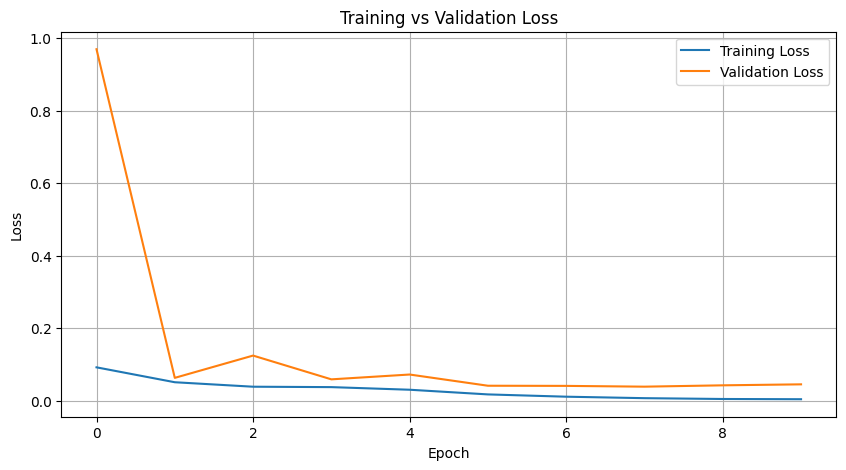

In [23]:
import matplotlib.pyplot as plt

# Combine losses from both phases
loss = history_phase1.history['loss'] + history_phase2.history['loss']
val_loss = history_phase1.history['val_loss'] + history_phase2.history['val_loss']

# Plot
plt.figure(figsize=(10, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# Step 1: Create a dummy subfolder inside /content/test
!mkdir -p /content/test/dummy
!mv /content/test/*.jpg /content/test/dummy/


mv: cannot stat '/content/test/*.jpg': No such file or directory


In [26]:
!rm -rf /content/test/dummy

In [27]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/test',  # points to folder containing 'test' subfolder
    target_size=(224, 224),
    batch_size=1,
    class_mode=None,
    shuffle=False
)


Found 12500 images belonging to 1 classes.


In [28]:
# Predict probabilities with your trained model
predictions = model.predict(test_generator, verbose=1)
preds_flat = predictions.ravel()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 84s 6ms/step


In [29]:
import pandas as pd
# Extract file IDs (like 1, 10, 100) from filenames
image_ids = [int(os.path.splitext(os.path.basename(path))[0]) for path in test_generator.filenames]

# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': image_ids,
    'label': preds_flat
})

# Sort by ID to match Kaggle requirement
submission_df = submission_df.sort_values('id')

# Save CSV
submission_df.to_csv('submission.csv', index=False)
print("csv is ready")


csv is ready


#### For the above submission, I got a log loss on Kaggle of around 0.14. Good start for a baseline model and needed to be explored further

In [30]:
!ls -lh


total 204K
drwx------ 7 root root 4.0K Apr 22 05:51 drive
drwxr-xr-x 1 root root 4.0K Apr 17 13:36 sample_data
-rw-r--r-- 1 root root 187K Apr 22 07:32 submission.csv
drwxr-xr-x 3 root root 4.0K Apr 22 07:26 test
drwxr-xr-x 4 root root 4.0K Apr 22 06:35 train


#### Trying out another approach with an ensemble of ResNet50, EfficientNetB0 and a custom CNN, to see if performance improves

In [31]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

def build_resnet50():
    base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    return Model(base.input, output)


In [32]:
from tensorflow.keras.applications import EfficientNetB0

def build_efficientnet():
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    return Model(base.input, output)


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

def build_custom_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model


In [40]:
def train_transfer_model(model_fn, name="model"):
    from tensorflow.keras.optimizers import Adam

    # 1. Build model
    model = model_fn()

    # 2. Freeze base layers
    for layer in model.layers:
        if hasattr(layer, 'trainable'):
            layer.trainable = False
        if 'conv1' in layer.name:  # Optionally unfreeze up to conv1
            break

    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    print(f"Training {name} with base frozen...")
    model.fit(train_gen, validation_data=val_gen, epochs=5)

    # 3. Unfreeze all
    for layer in model.layers:
        if hasattr(layer, 'trainable'):
            layer.trainable = True

    model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    print(f"Fine-tuning full {name} model...")
    model.fit(train_gen, validation_data=val_gen, epochs=5)

    return model


In [41]:
resnet_model = train_transfer_model(build_resnet50, name="ResNet50")
effnet_model = train_transfer_model(build_efficientnet, name="EfficientNetB0")

custom_model = build_custom_cnn()
custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
custom_model.fit(train_gen, validation_data=val_gen, epochs=5)


Training ResNet50 with base frozen...
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 333s 441ms/step - accuracy: 0.9439 - loss: 0.1354 - val_accuracy: 0.7682 - val_loss: 0.4837
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 270s 432ms/step - accuracy: 0.9819 - loss: 0.0501 - val_accuracy: 0.9758 - val_loss: 0.0718
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 271s 433ms/step - accuracy: 0.9866 - loss: 0.0374 - val_accuracy: 0.9694 - val_loss: 0.0860
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 269s 431ms/step - accuracy: 0.9903 - loss: 0.0290 - val_accuracy: 0.9750 - val_loss: 0.0675
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 270s 432ms/step - accuracy: 0.9889 - loss: 0.0293 - val_accuracy: 0.9722 - val_loss: 0.0863
Fine-tuning full ResNet50 model...
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 333s 444ms/step - accuracy: 0.9929 - loss: 0.0183 - val_accuracy: 0.9852 - val_loss: 0.0401
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 271s 434ms/step - accuracy: 0.9969 - loss: 0.0092 - val_accuracy: 0.9874 - val_loss: 0.0417
Epoch 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


625/625 ━━━━━━━━━━━━━━━━━━━━ 291s 442ms/step - accuracy: 0.4934 - loss: 0.7160 - val_accuracy: 0.5000 - val_loss: 0.7029
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 268s 428ms/step - accuracy: 0.4968 - loss: 0.7150 - val_accuracy: 0.5000 - val_loss: 0.7029
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 269s 430ms/step - accuracy: 0.4984 - loss: 0.7140 - val_accuracy: 0.5000 - val_loss: 0.7030
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 266s 426ms/step - accuracy: 0.5046 - loss: 0.7127 - val_accuracy: 0.5000 - val_loss: 0.7030
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 265s 424ms/step - accuracy: 0.4989 - loss: 0.7140 - val_accuracy: 0.5000 - val_loss: 0.7029
Fine-tuning full EfficientNetB0 model...
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 350s 447ms/step - accuracy: 0.7241 - loss: 0.5321 - val_accuracy: 0.8374 - val_loss: 0.3386
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 272s 434ms/step - accuracy: 0.9495 - loss: 0.1524 - val_accuracy: 0.9162 - val_loss: 0.2173
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 269s 430ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 269s 427ms/step - accuracy: 0.5800 - loss: 0.9349 - val_accuracy: 0.6618 - val_loss: 0.6229
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 267s 428ms/step - accuracy: 0.6663 - loss: 0.6185 - val_accuracy: 0.6666 - val_loss: 0.6076
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 264s 423ms/step - accuracy: 0.7117 - loss: 0.5619 - val_accuracy: 0.7536 - val_loss: 0.5138
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 269s 430ms/step - accuracy: 0.7513 - loss: 0.5148 - val_accuracy: 0.7772 - val_loss: 0.4754
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 266s 426ms/step - accuracy: 0.7684 - loss: 0.4847 - val_accuracy: 0.7800 - val_loss: 0.4627


In [42]:
# Reset the test generator before each prediction
test_generator.reset()
resnet_preds = resnet_model.predict(test_generator, verbose=1)

test_generator.reset()
effnet_preds = effnet_model.predict(test_generator, verbose=1)

test_generator.reset()
custom_preds = custom_model.predict(test_generator, verbose=1)

# Average the predictions
ensemble_preds = (resnet_preds + effnet_preds + custom_preds) / 3
final_preds = ensemble_preds.ravel()


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step


In [43]:
import numpy as np
import pandas as pd

image_ids = [int(os.path.splitext(os.path.basename(path))[0]) for path in test_generator.filenames]

submission_df = pd.DataFrame({
    'id': image_ids,
    'label': np.clip(final_preds, 1e-5, 1 - 1e-5)  # Clip for stable log loss
}).sort_values('id')

submission_df.to_csv('submission_ensemble.csv', index=False)
print("✅ Ensemble submission saved.")
submission_path = '/content/drive/MyDrive/submission_ensemble.csv'
submission_df.to_csv(submission_path, index=False)
print(f"✅ Submission saved to: {submission_path}")



✅ Ensemble submission saved.
✅ Submission saved to: /content/drive/MyDrive/submission_ensemble.csv


#### In this ensemble, I got a loss of around 0.14 again, so did not see any notable improvement.

#### Again Proceeding with another ensemble method

 - First, we will do 5-fold cross-validation to improve robustness of final model
 - Changed base model to EfficientNetB0
 - Created an ensemble of 5 models

In [14]:
import pandas as pd
import glob
import os

# Step 1: Point to the actual image location
image_paths = glob.glob('/content/train/train/*.jpg')

# Step 2: Create DataFrame with inferred labels
data = []
for path in image_paths:
    fname = os.path.basename(path)
    label = 'dog' if "dog" in fname.lower() else 'cat'  # Ensure labels are strings
    data.append({'filename': path, 'label': label})

train_df = pd.DataFrame(data)
print(train_df.head())


                             filename label
0  /content/train/train/cat.12147.jpg   cat
1   /content/train/train/cat.8322.jpg   cat
2   /content/train/train/dog.7215.jpg   dog
3   /content/train/train/dog.5234.jpg   dog
4   /content/train/train/dog.1390.jpg   dog


In [9]:
test_df = pd.DataFrame({
    'filename': sorted(glob.glob('/content/test/test/*.jpg'))
})


In [16]:
print(f"Total images: {len(train_df)}")
print(f"Dogs: {(train_df['label'] == 'dog').sum()}, Cats: {(train_df['label'] == 'cat').sum()}")


Total images: 25000
Dogs: 12500, Cats: 12500


In [11]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import KFold
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

In [12]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
KFOLDS = 5
models = []
preds = []


In [17]:
# K-Fold CV
kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
    print(f"\n===== Fold {fold+1}/{KFOLDS} =====")
    K.clear_session()

    train_data = train_df.iloc[train_idx].reset_index(drop=True)
    val_data = train_df.iloc[val_idx].reset_index(drop=True)

    train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.2,
        horizontal_flip=True
    ).flow_from_dataframe(
        train_data,
        x_col='filename', y_col='label',
        target_size=IMG_SIZE,
        class_mode='binary',
        batch_size=BATCH_SIZE
    )

    val_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        val_data,
        x_col='filename', y_col='label',
        target_size=IMG_SIZE,
        class_mode='binary',
        batch_size=BATCH_SIZE
    )

    # Build model
    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Phase 1: freeze base
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS,
              callbacks=[EarlyStopping(patience=2, restore_best_weights=True)])

    # Phase 2: unfreeze base
    for layer in base_model.layers:
        layer.trainable = True
    model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS,
              callbacks=[EarlyStopping(patience=2, restore_best_weights=True)])

    models.append(model)
    print(f"✅ Fold {fold+1} complete.")



===== Fold 1/5 =====
Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 273s 377ms/step - accuracy: 0.5349 - loss: 0.6899 - val_accuracy: 0.5882 - val_loss: 0.6725
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 218s 349ms/step - accuracy: 0.5756 - loss: 0.6763 - val_accuracy: 0.6062 - val_loss: 0.6669
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 218s 349ms/step - accuracy: 0.5873 - loss: 0.6722 - val_accuracy: 0.6044 - val_loss: 0.6641
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 218s 348ms/step - accuracy: 0.5885 - loss: 0.6730 - val_accuracy: 0.6052 - val_loss: 0.6629
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 220s 352ms/step - accuracy: 0.5883 - loss: 0.6705 - val_accuracy: 0.5956 - val_loss: 0.6648
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 352s 375ms/step - accuracy: 0.7223 - loss: 0.5309 - val_accuracy: 0.9476 - val_loss: 0.1617
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 221s 353ms/step - accuracy: 0.9551 - loss: 0.1264 - val_accuracy: 0.9778 - val_loss: 0.0720
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 220s 352ms/step - accuracy: 0.9709 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 265s 374ms/step - accuracy: 0.5436 - loss: 0.6875 - val_accuracy: 0.6198 - val_loss: 0.6689
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 220s 353ms/step - accuracy: 0.5616 - loss: 0.6802 - val_accuracy: 0.5956 - val_loss: 0.6667
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 219s 351ms/step - accuracy: 0.5841 - loss: 0.6720 - val_accuracy: 0.5856 - val_loss: 0.6688
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 221s 353ms/step - accuracy: 0.5822 - loss: 0.6735 - val_accuracy: 0.6142 - val_loss: 0.6559
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 221s 354ms/step - accuracy: 0.5810 - loss: 0.6748 - val_accuracy: 0.6056 - val_loss: 0.6600
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 346s 378ms/step - accuracy: 0.7547 - loss: 0.4902 - val_accuracy: 0.9332 - val_loss: 0.1824
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 223s 356ms/step - accuracy: 0.9570 - loss: 0.1235 - val_accuracy: 0.9778 - val_loss: 0.0616
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 223s 356ms/step - accuracy: 0.9738 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 261s 368ms/step - accuracy: 0.5445 - loss: 0.6872 - val_accuracy: 0.5956 - val_loss: 0.6703
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 219s 351ms/step - accuracy: 0.5800 - loss: 0.6753 - val_accuracy: 0.6098 - val_loss: 0.6651
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 220s 353ms/step - accuracy: 0.5815 - loss: 0.6722 - val_accuracy: 0.6068 - val_loss: 0.6658
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 218s 349ms/step - accuracy: 0.5870 - loss: 0.6722 - val_accuracy: 0.6072 - val_loss: 0.6640
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 221s 353ms/step - accuracy: 0.5961 - loss: 0.6693 - val_accuracy: 0.6088 - val_loss: 0.6630
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 349s 382ms/step - accuracy: 0.7640 - loss: 0.4770 - val_accuracy: 0.9634 - val_loss: 0.1178
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 222s 355ms/step - accuracy: 0.9564 - loss: 0.1211 - val_accuracy: 0.9642 - val_loss: 0.0909
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 222s 355ms/step - accuracy: 0.9727 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 266s 375ms/step - accuracy: 0.5393 - loss: 0.6903 - val_accuracy: 0.5868 - val_loss: 0.6687
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 218s 349ms/step - accuracy: 0.5827 - loss: 0.6752 - val_accuracy: 0.6180 - val_loss: 0.6569
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 220s 352ms/step - accuracy: 0.5797 - loss: 0.6732 - val_accuracy: 0.6088 - val_loss: 0.6607
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 221s 353ms/step - accuracy: 0.5937 - loss: 0.6684 - val_accuracy: 0.6170 - val_loss: 0.6573
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 350s 380ms/step - accuracy: 0.7537 - loss: 0.4863 - val_accuracy: 0.9586 - val_loss: 0.1267
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 223s 357ms/step - accuracy: 0.9579 - loss: 0.1233 - val_accuracy: 0.9714 - val_loss: 0.0751
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 222s 355ms/step - accuracy: 0.9704 - loss: 0.0773 - val_accuracy: 0.9862 - val_loss: 0.0382
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 223s 356ms/step - accuracy: 0.9792 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 267s 376ms/step - accuracy: 0.5403 - loss: 0.6886 - val_accuracy: 0.5890 - val_loss: 0.6711
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 221s 353ms/step - accuracy: 0.5786 - loss: 0.6749 - val_accuracy: 0.6098 - val_loss: 0.6612
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 219s 350ms/step - accuracy: 0.5872 - loss: 0.6704 - val_accuracy: 0.6016 - val_loss: 0.6642
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 221s 354ms/step - accuracy: 0.5848 - loss: 0.6705 - val_accuracy: 0.6102 - val_loss: 0.6586
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 222s 355ms/step - accuracy: 0.5917 - loss: 0.6700 - val_accuracy: 0.6082 - val_loss: 0.6595
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 345s 379ms/step - accuracy: 0.7702 - loss: 0.4696 - val_accuracy: 0.9610 - val_loss: 0.1220
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 224s 358ms/step - accuracy: 0.9545 - loss: 0.1170 - val_accuracy: 0.9848 - val_loss: 0.0531
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 226s 361ms/step - accuracy: 0.9711 - loss: 0

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test_df,
    x_col='filename',
    target_size=IMG_SIZE,
    class_mode=None,
    shuffle=False,
    batch_size=1
)


Found 12500 validated image filenames.


In [19]:
import numpy as np

all_preds = []

for i, model in enumerate(models):
    print(f"Predicting with model {i+1}")
    test_gen.reset()
    preds = model.predict(test_gen, verbose=0)
    all_preds.append(preds)

# Average predictions across all folds
final_preds = np.mean(all_preds, axis=0).ravel()

# Clip values to avoid log loss issues
final_preds = np.clip(final_preds, 1e-5, 1 - 1e-5)


Predicting with model 1
Predicting with model 2
Predicting with model 3
Predicting with model 4
Predicting with model 5


In [20]:
# Extract just the image IDs from filenames
test_ids = [int(f.split('/')[-1].split('.')[0]) for f in test_df['filename']]

submission = pd.DataFrame({
    'id': test_ids,
    'label': final_preds
}).sort_values('id')

submission.to_csv('submission_efficientNet.csv', index=False)
print("submission.csv is ready!")


submission.csv is ready!
